In [36]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

In [38]:
# Loading the dataset
data = pd.read_csv('/Users/vishakkrishnan/Documents/data/customer_booking.csv', encoding='ISO-8859-1')

In [40]:
#Viewing the first five rows
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [42]:
#Viewing the data description
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [44]:
#Summary of the statistics
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [46]:
# Preprocess the dataset: reducing categories and one-hot encoding
top_routes = data['route'].value_counts().nlargest(50).index
data['route'] = data['route'].apply(lambda x: x if x in top_routes else 'Other')
top_origins = data['booking_origin'].value_counts().nlargest(30).index
data['booking_origin'] = data['booking_origin'].apply(lambda x: x if x in top_origins else 'Other')

categorical_vars = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
encoder = OneHotEncoder(sparse_output=True)
encoded_data = encoder.fit_transform(data[categorical_vars])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoder.get_feature_names_out(categorical_vars))

# Convert sparse DataFrame to a dense DataFrame
encoded_df = encoded_df.sparse.to_dense()

# Concatenate with the original data
data_preprocessed = pd.concat([data.drop(categorical_vars, axis=1), encoded_df], axis=1)

In [48]:
# Define features and target
X = data_preprocessed.drop('booking_complete', axis=1)
y = data_preprocessed['booking_complete']

# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Optionally select the top N most informative features
top_features = mi_scores.head(10).index
X_selected = X[top_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print('AUC score: ',roc_auc_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8520
           1       0.37      0.16      0.22      1480

    accuracy                           0.84     10000
   macro avg       0.62      0.55      0.56     10000
weighted avg       0.79      0.84      0.81     10000

Accuracy: 83.50999999999999
AUC score:  0.5545663621367847


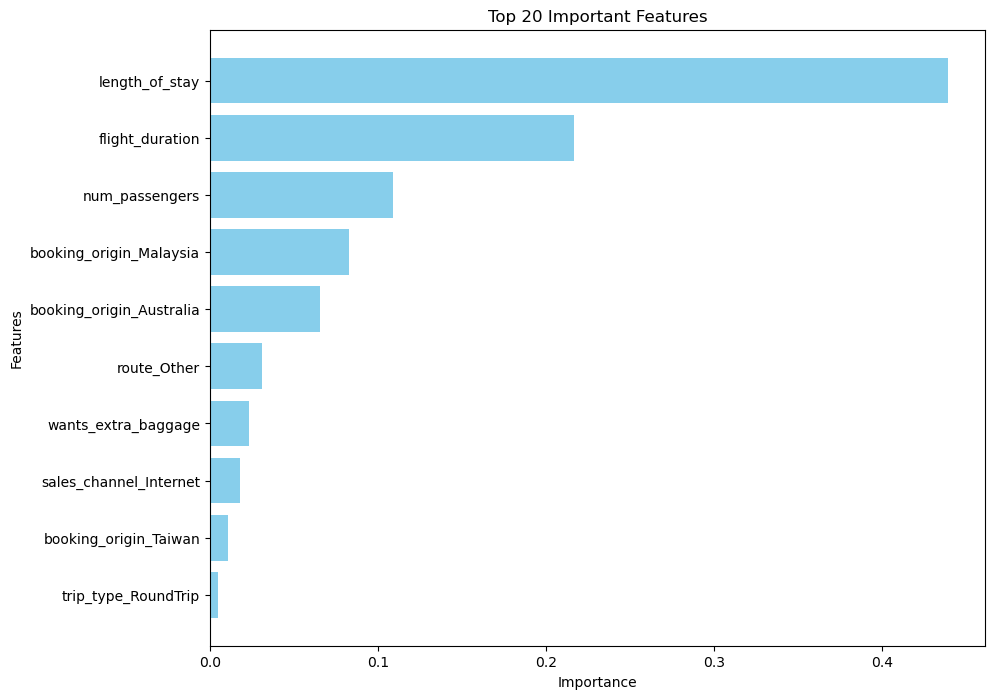

In [50]:
#Plotting the top 20 features using a horizontal bar chart to visualize which features have the most impact on the model's predictions.
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_sorted['Feature'][:20], feature_importances_sorted['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.show()